# Solving Sudoku with Quantum Computing

This Jupyter notebook demonstrates how to solve a Sudoku puzzle using quantum computing. Sudoku is a popular puzzle game that requires filling a 9x9 grid so that each column, each row, and each of the nine 3x3 subgrids contain all the digits from 1 to 9. Quantum computing offers new possibilities for solving complex problems efficiently. Here, we will explore how to leverage quantum algorithms to find solutions to Sudoku puzzles.


In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

## Creating a W-State

A W-State is a specific type of entangled quantum state. In a 3-qubit system, a W-State is of the form:

$ |W\rangle = \frac{1}{\sqrt{3}}(|100\rangle + |010\rangle + |001\rangle) $

This state can be generalized to more qubits. We will create a function to generate a W-State.


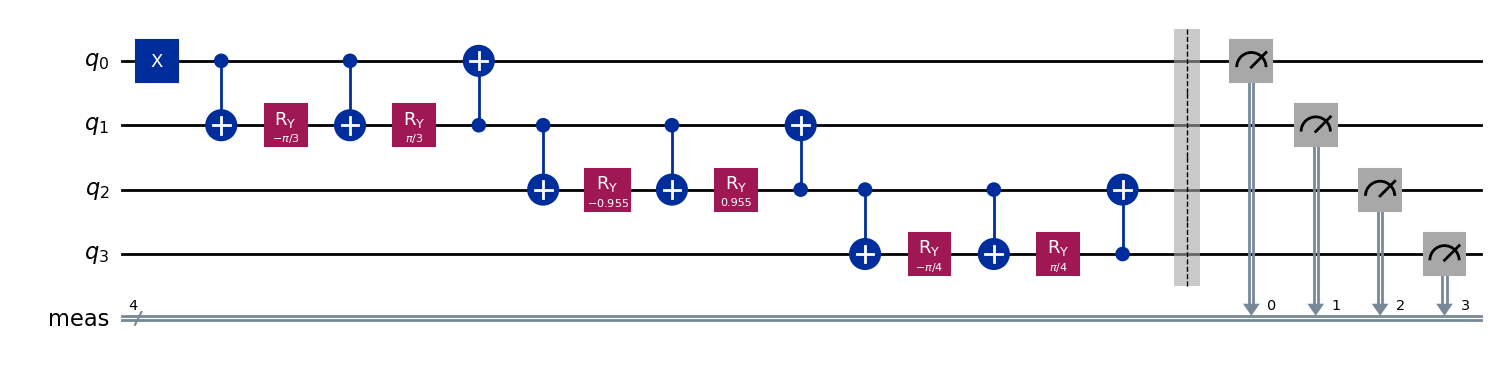

In [2]:
from wstates import prepare_w_state

qc = QuantumCircuit(4)

prepare_w_state(qc, [0,1,2,3])

qc.measure_all()

qc.draw('mpl')

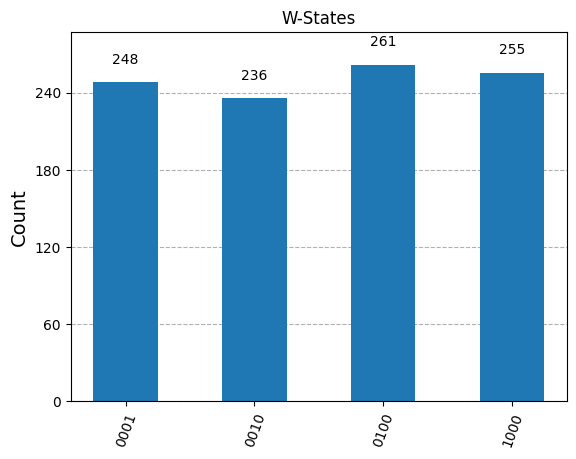

In [3]:
# Construct an ideal simulator
simulator = AerSimulator()
qc = transpile(qc, simulator)

# Perform an ideal simulation
result = simulator.run(qc, shots=1000).result()
counts = result.get_counts(qc)
plot_histogram(counts, title='W-States')

We can also prepare W-States controlled on a specific set of qubits

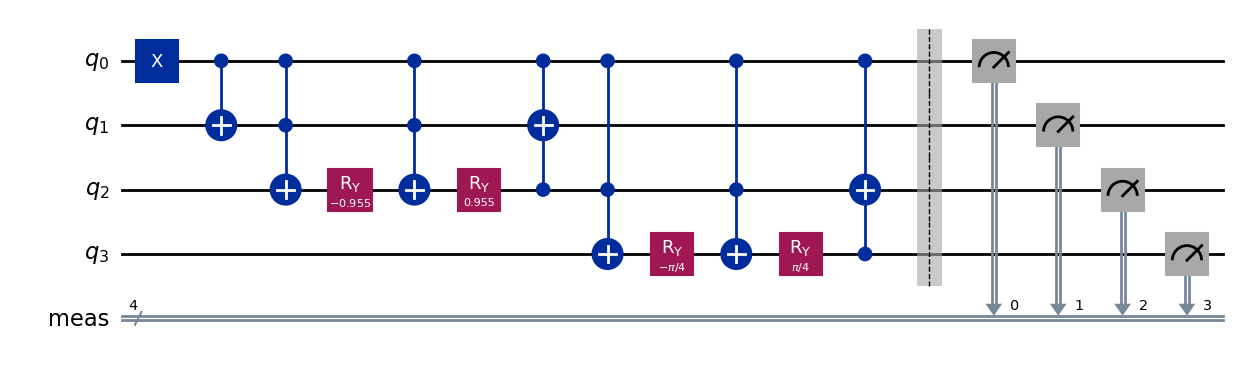

In [4]:
from wstates import prepare_controlled_w_state

qc = QuantumCircuit(4)

qc.x(0)

prepare_controlled_w_state(qc, [1,2,3], [0])

qc.measure_all()

qc.draw('mpl')

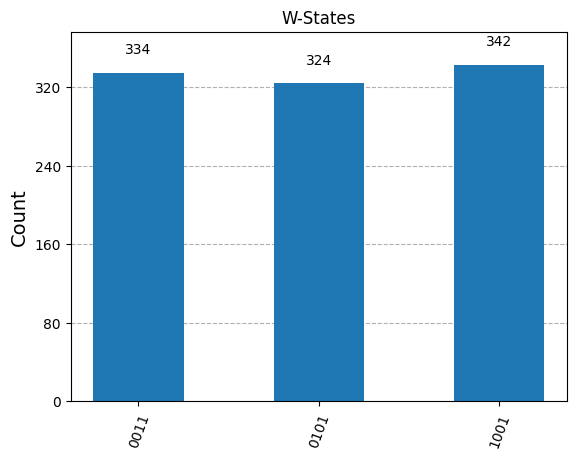

In [5]:
# Construct an ideal simulator
simulator = AerSimulator()
qc = transpile(qc, simulator)

# Perform an ideal simulation
result = simulator.run(qc, shots=1000).result()
counts = result.get_counts(qc)
plot_histogram(counts, title='W-States')

With this knowledge, we can jump into our approach of solving **Sudoku** puzzles

## 4x4 Sudoku

Below is an example of hard 4x4 sudoku puzzle

In this example, we use `preset_tuples` to initialize specific cells in the Sudoku grid. Each tuple in `preset_tuples` represents a cell in the grid where:

- The first element is the row index.
- The second element is the column index.
- The third element is the value to be placed in that cell.

This is one representation of a sudoku grid, we will also be seeing another representation soon! 

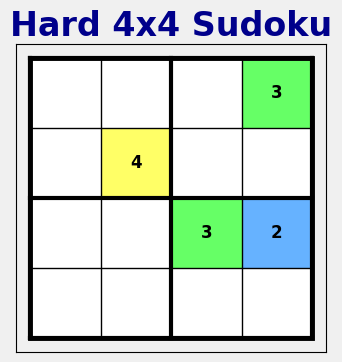

In [6]:
from sudoku import draw_sudoku_grid

preset_tuples = [(1, 1, 4), (2, 2, 3), (0, 3, 3), (2, 3, 2)]

draw_sudoku_grid(preset_tuples, 4, "Hard 4x4 Sudoku")

In [7]:
from sudoku import generate_sudoku_bitstrings

solution = generate_sudoku_bitstrings(preset_tuples, 4)
solution

{1: '0000000000000000',
 2: '0000000000010000',
 3: '0001000000100000',
 4: '0000010000000000'}

The output of `generate_sudoku_bitstrings` is a set of bitstrings, where each bitstring represents a potential solution or state of the Sudoku puzzle. Each bit in the string corresponds to a specific cell in the grid.

For instance, a bitstring `1010 0100 0011 1100` (for a 4x4 grid) might represent a certain configuration of the grid where:
- `1` could mean a cell is filled with a certain value.
- `0` could mean a cell is empty or has another value.

By converting the Sudoku puzzle into bitstrings, we can utilize quantum algorithms to find the solution efficiently.


In [8]:
block1 = [0,1,4,5]
block2 = [2,3,6,7]
block3 = [8,9,12,13]
block4 = [10,11,14,15]

blocks = [block1, block2, block3, block4]

Above are the indices of the internal blocks of a 4x4 sudoku collected together

The last two qubits are `ancillary qubits`, they are the ones which help us to find the solutions we need, when both of these ancillary tend to excited state $ |1\rangle $, that combination would be the potential solution

[6, 7] [0]
[9, 11] [0, 6]
[9, 10] [0, 7]
[6, 7] [1]
[8, 11] [1, 6]
[8, 10] [1, 7]
[4, 5] [2]
[9, 11] [2, 4]
[8, 11] [2, 5]
[4, 5] [3]
[9, 10] [3, 4]
[8, 10] [3, 5]


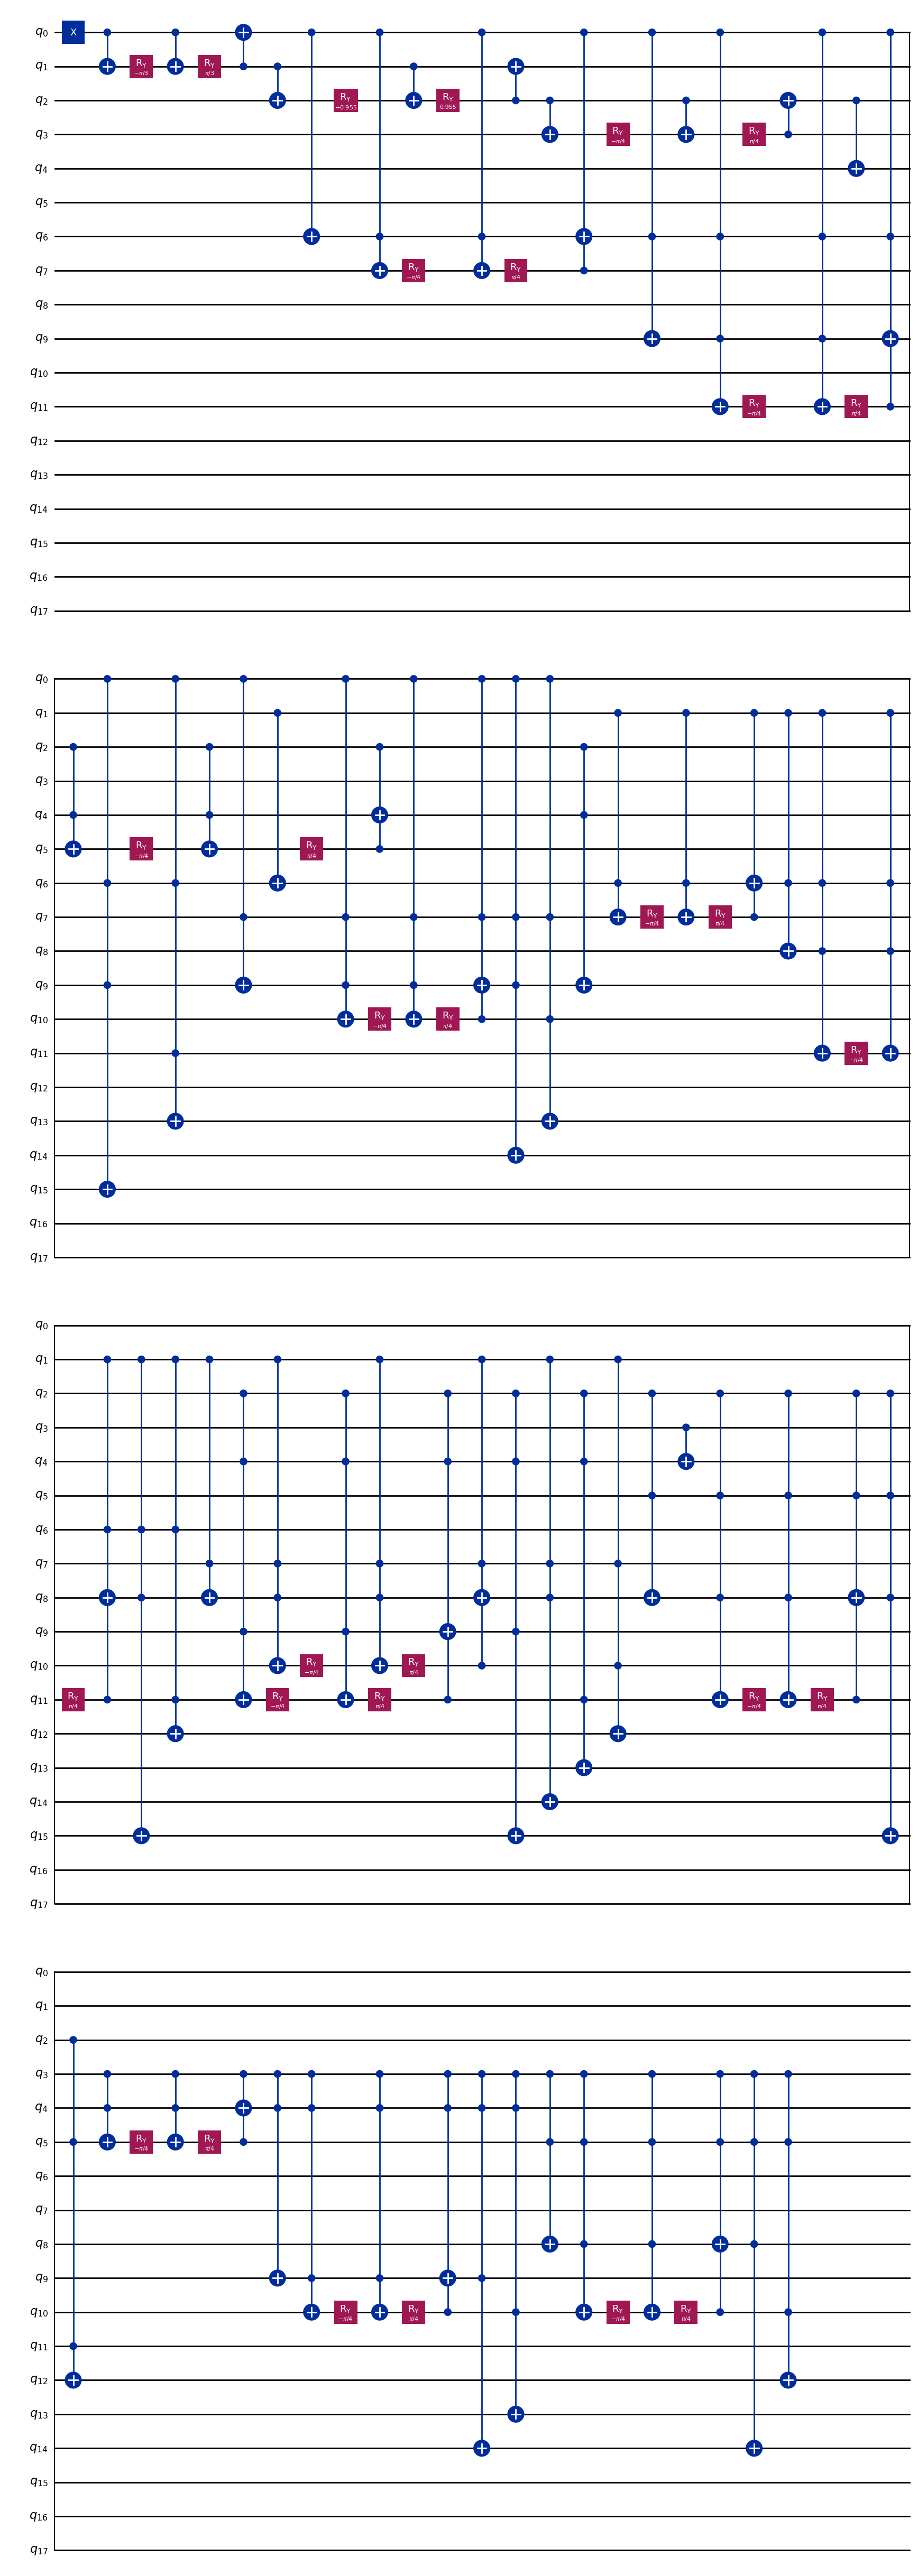

In [9]:
from wstates import traverse_quantum_blocks

circ = QuantumCircuit(16+2)

row_1 = [0,1,2,3]
row_2 = [4, 5, 6, 7]

prepare_w_state(circ, row_1)

for i in range(len(row_1)):
    nrow = row_2.copy()
    nrow.remove(row_1[i]+4)
    cblocks = blocks.copy()
    traverse_quantum_blocks(4, cblocks, [row_1[i]], nrow, circ)

circ.draw('mpl')

The circuit created above is the main circuit and and we would be reusing this circuit each time for finding the positions of every numbers

### Measuring the above circuit, gives every possible positions for a number in a 4x4 Sudoku grid

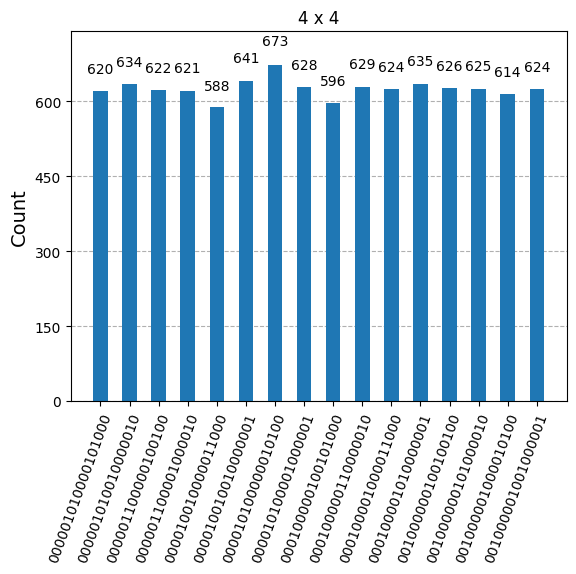

In [10]:
circ.measure_all()

# Construct an ideal simulator
simulator = AerSimulator()
circ = transpile(circ, simulator)

# Perform an ideal simulation
result = simulator.run(circ, shots=10000).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='4 x 4')

Let us remove the measurement from the above circuit to use it to encode our sudoku puzzle to the circuit

In [11]:
circ.remove_final_measurements()

circ.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=18, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(18, 'q'), 0), Qubit(QuantumRegister(18, 'q'), 1), Qubit(QuantumRegister(18, 'q'), 2), Qubit(QuantumRegister(18, 'q'), 3), Qubit(QuantumRegister(18, 'q'), 4), Qubit(QuantumRegister(18, 'q'), 5), Qubit(QuantumRegister(18, 'q'), 6), Qubit(QuantumRegister(18, 'q'), 7), Qubit(QuantumRegister(18, 'q'), 8), Qubit(QuantumRegister(18, 'q'), 9), Qubit(QuantumRegister(18, 'q'), 10), Qubit(QuantumRegister(18, 'q'), 11), Qubit(QuantumRegister(18, 'q'), 12), Qubit(QuantumRegister(18, 'q'), 13), Qubit(QuantumRegister(18, 'q'), 14), Qubit(QuantumRegister(18, 'q'), 15), Qubit(QuantumRegister(18, 'q'), 16), Qubit(QuantumRegister(18, 'q'), 17)), clbits=())

## Now let us try to solve for positions of each numbers one by one

### Let us start with digit `3`

In [12]:
from helper_functions import find_control_indices_for_sudoku

list3, listo = find_control_indices_for_sudoku(solution, 3)

- `list3` - Indices of cells hosting the digit **3**
- `listo` - Indices of cells hosting all the digits **other than 3**

In [13]:
list3

[3, 10]

In [14]:
listo

[11, 5]

In [15]:
from helper_functions import apply_multi_qubit_or

# encoding the positions of 3 and making them to control the 1st ancillary qubit
circ.mcx(list3, 16)

# Initializing the 2nd ancillary qubit
circ.x(17)

# encoding the positions of all digits other than 3 and making them to control the 2nd ancillary qubit
apply_multi_qubit_or(circ, listo, 17)

circ.measure_all()

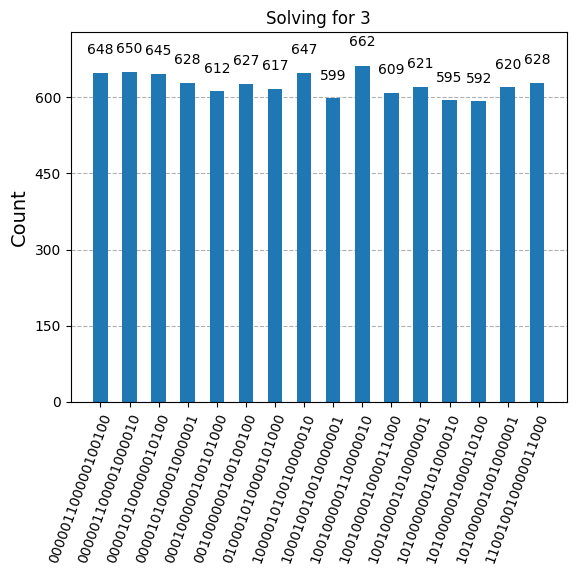

In [16]:
# Construct an ideal simulator
simulator = AerSimulator()
circ = transpile(circ, simulator)

# Perform an ideal simulation
result = simulator.run(circ, shots=10000).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Solving for 3')

Now, we need to extract the combination, in which the first two bits are `1`, in other words ancillary qubits measured to be `1`

**NOTE** : In qiskit, the bitstrings are reversed

In [17]:
solution

{1: '0000000000000000',
 2: '0000000000010000',
 3: '0001000000100000',
 4: '0000010000000000'}

In [18]:
from helper_functions import filter_and_reverse_bitstrings

solution[3] = filter_and_reverse_bitstrings(counts, '11')[0]

solution[3]

'0001100000100100'

The above bitstring represents the indices of the digit `3`

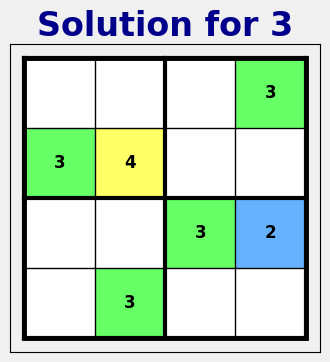

In [19]:
from sudoku import decode_sudoku_bitstrings

preset_tuples = decode_sudoku_bitstrings(solution, 4)

draw_sudoku_grid(preset_tuples, 4, "Solution for 3")

### Now, let us solve for digit `2`

Before that we need to remove the measurements and the encoding, we did for finding the solution for the digit `3`

In [20]:
from helper_functions import count_gates_between_first_two_barriers

n_gates_rm = count_gates_between_first_two_barriers(circ)
n_gates_rm

8

In [21]:
circ.remove_final_measurements()

for _ in range(n_gates_rm):
    circ.data.pop()

Let us now, start solving for digit `2`

In [22]:
list2, listo = find_control_indices_for_sudoku(solution, 2)

In [23]:
list2, listo

([11], [3, 4, 10, 13, 5])

Let us encode for digit `2`

In [24]:
circ.mcx(list2, 16)

circ.x(17)

apply_multi_qubit_or(circ, listo, 17)

circ.measure_all()

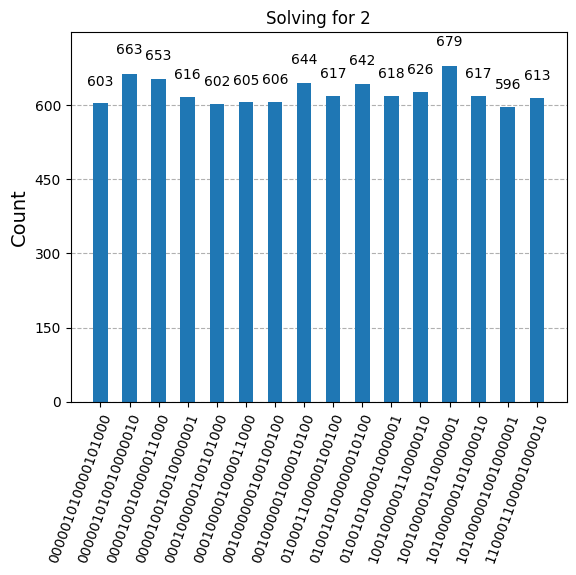

In [25]:
# Construct an ideal simulator
simulator = AerSimulator()
circ = transpile(circ, simulator)

# Perform an ideal simulation
result = simulator.run(circ, shots=10000).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Solving for 2')

In [26]:
solution[2] = filter_and_reverse_bitstrings(counts, '11')[0]

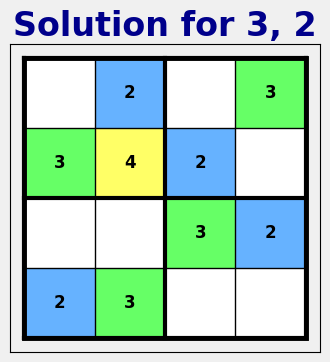

In [27]:
from sudoku import decode_sudoku_bitstrings

preset_tuples = decode_sudoku_bitstrings(solution, 4)

draw_sudoku_grid(preset_tuples, 4, "Solution for 3, 2")

### Let us solve for digit `4`

In [28]:
from helper_functions import count_gates_between_first_two_barriers

n_gates_rm = count_gates_between_first_two_barriers(circ)
n_gates_rm

14

In [29]:
circ.remove_final_measurements()

for _ in range(n_gates_rm):
    circ.data.pop()

In [30]:
list4, listo = find_control_indices_for_sudoku(solution, 4)

In [31]:
list4, listo

([5], [1, 6, 11, 12, 3, 4, 10, 13])

In [32]:
circ.mcx(list4, 16)

circ.x(17)

apply_multi_qubit_or(circ, listo, 17)

circ.measure_all()

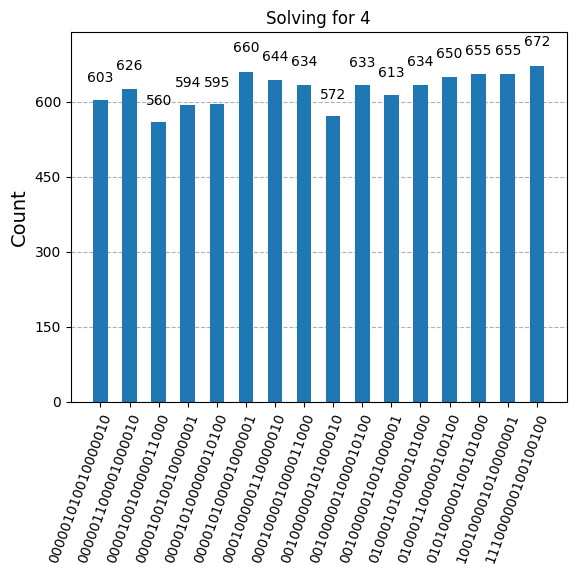

In [33]:
# Construct an ideal simulator
simulator = AerSimulator()
circ = transpile(circ, simulator)

# Perform an ideal simulation
result = simulator.run(circ, shots=10000).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Solving for 4')

In [34]:
solution[4] = filter_and_reverse_bitstrings(counts, '11')[0]

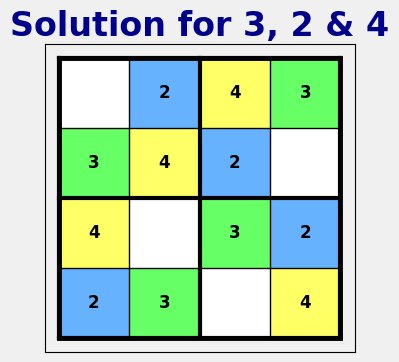

In [35]:
from sudoku import decode_sudoku_bitstrings

preset_tuples = decode_sudoku_bitstrings(solution, 4)

draw_sudoku_grid(preset_tuples, 4, "Solution for 3, 2 & 4")

### Let us solve for digit `1`

As we reached to find the combination of final digit, we don't necessarily need to encode for this number and re-run the circuit. We can simply fill the empty with the final number. Else mathematically, we can do **OR** operation on bitstrings of all numbers except the final one and **NOT** the resultant bitstring, to ontain the solution for the final digit.

In [36]:
from helper_functions import calculate_negated_or_bitstring

solution[1] = calculate_negated_or_bitstring(solution, 1)

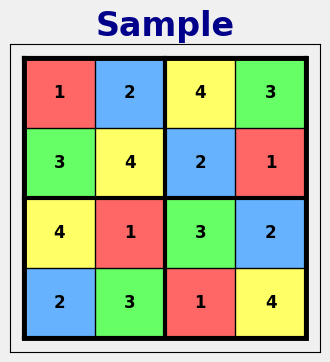

In [37]:
preset_tuples = decode_sudoku_bitstrings(solution, 4)

draw_sudoku_grid(preset_tuples, 4, 'Sample')

In [38]:
circ.depth()

81

Yayy! We solved the 4x4 Sudoku puzzle

# 9x9 Sudoku

Let us now start solving for 9x9 Sudoku, we can try to solve `AI Escargot` which is the hardest 9x9 Sudoku puzzle, the world has ever seen!

## AI Escargot

In [39]:
preset_tuples = [(0, 0, 1), (0, 5, 7), (0, 7, 9), (1, 1, 3), (1, 4, 2), (1, 8, 8), (2, 2, 9), (2, 3, 6), (2, 6, 5), (3, 2, 5), (3, 3, 3), (3, 6, 9), (4, 1, 1), (4, 4, 8), (4, 8, 2), (5, 0, 6), (5, 5, 4), (6, 0, 3), (6, 7, 1), (7, 1, 4), (7, 8, 7), (8, 2, 7), (8, 6, 3)]

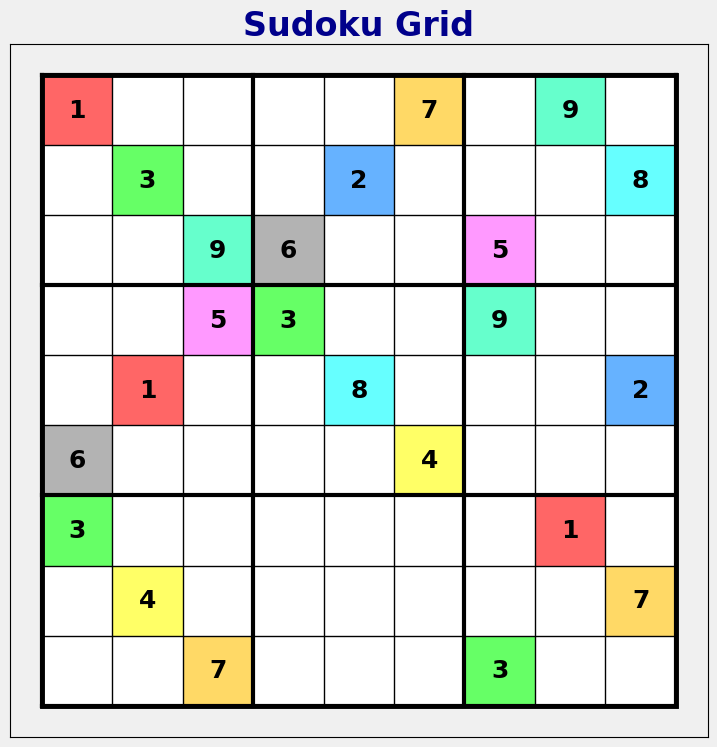

In [40]:
draw_sudoku_grid(preset_tuples, 9)

Let us generate the bitstrings representation of this problem

In [41]:
solution = generate_sudoku_bitstrings(preset_tuples, 9)
solution

{1: '100000000000000000000000000000000000010000000000000000000000010000000000000000000',
 2: '000000000000010000000000000000000000000000001000000000000000000000000000000000000',
 3: '000000000010000000000000000000100000000000000000000000100000000000000000000000100',
 4: '000000000000000000000000000000000000000000000000001000000000000010000000000000000',
 5: '000000000000000000000000100001000000000000000000000000000000000000000000000000000',
 6: '000000000000000000000100000000000000000000000100000000000000000000000000000000000',
 7: '000001000000000000000000000000000000000000000000000000000000000000000001001000000',
 8: '000000000000000001000000000000000000000010000000000000000000000000000000000000000',
 9: '000000010000000000001000000000000100000000000000000000000000000000000000000000000'}

Let us group the indices of the cells, belonging to the same block

In [42]:
blocks = [[] for _ in range(9)]

ls = [i for i in range(81)]

start = 0
stop = 3
sup = 0
for i in range(3):
    for j in range(3):
        for k in range(3):
            blocks[k+sup] += ls[start:stop]
            start += 3
            stop += 3
    sup += 3

In [43]:
blocks

[[0, 1, 2, 9, 10, 11, 18, 19, 20],
 [3, 4, 5, 12, 13, 14, 21, 22, 23],
 [6, 7, 8, 15, 16, 17, 24, 25, 26],
 [27, 28, 29, 36, 37, 38, 45, 46, 47],
 [30, 31, 32, 39, 40, 41, 48, 49, 50],
 [33, 34, 35, 42, 43, 44, 51, 52, 53],
 [54, 55, 56, 63, 64, 65, 72, 73, 74],
 [57, 58, 59, 66, 67, 68, 75, 76, 77],
 [60, 61, 62, 69, 70, 71, 78, 79, 80]]

## Let us build the main circuit

In [44]:
circ9 = QuantumCircuit(81+2)

row_1 = [0,1,2,3,4,5,6,7,8]
row_2 = [9,10,11,12,13,14,15,16,17]

prepare_w_state(circ9, row_1)

for i in range(len(row_1)):
    nrow = row_2.copy()
    nrow.remove(row_1[i]+9)
    cblocks = blocks.copy()
    traverse_quantum_blocks(9, cblocks, [row_1[i]], nrow, circ9)

circ9.barrier()

circ9.measure_all()

# circ9.draw('mpl')

[12, 13, 14, 15, 16, 17] [0]
[24, 25, 26] [0, 12]
[28, 29, 31, 32, 34, 35] [0, 12, 24]
[40, 41, 43, 44] [0, 12, 24, 28]
[52, 53] [0, 12, 24, 28, 40]
[56, 59, 62] [0, 12, 24, 28, 40, 52]
[68, 71] [0, 12, 24, 28, 40, 52, 56]
[65, 71] [0, 12, 24, 28, 40, 52, 59]
[65, 68] [0, 12, 24, 28, 40, 52, 62]
[56, 59, 61] [0, 12, 24, 28, 40, 53]
[68, 70] [0, 12, 24, 28, 40, 53, 56]
[65, 70] [0, 12, 24, 28, 40, 53, 59]
[65, 68] [0, 12, 24, 28, 40, 53, 61]
[52, 53] [0, 12, 24, 28, 41]
[56, 58, 62] [0, 12, 24, 28, 41, 52]
[67, 71] [0, 12, 24, 28, 41, 52, 56]
[65, 71] [0, 12, 24, 28, 41, 52, 58]
[65, 67] [0, 12, 24, 28, 41, 52, 62]
[56, 58, 61] [0, 12, 24, 28, 41, 53]
[67, 70] [0, 12, 24, 28, 41, 53, 56]
[65, 70] [0, 12, 24, 28, 41, 53, 58]
[65, 67] [0, 12, 24, 28, 41, 53, 61]
[49, 50] [0, 12, 24, 28, 43]
[56, 59, 62] [0, 12, 24, 28, 43, 49]
[68, 71] [0, 12, 24, 28, 43, 49, 56]
[65, 71] [0, 12, 24, 28, 43, 49, 59]
[65, 68] [0, 12, 24, 28, 43, 49, 62]
[56, 58, 62] [0, 12, 24, 28, 43, 50]
[67, 71] [0, 12,

In [45]:
circ9.depth()

315887

Since the number of qubits is high and the depth of the circuit is too large, we won't be able to simulate this circuit

### Now, let us try spliing the circuit for each digit and running them separately

First, let us start with `1`, the position of digit `1` in first row is `0`. So, let us first build a circuit to compute all the combinations of positions of a digit positioned at index `0`

In [46]:
circ9 = QuantumCircuit(81+2)

row_1 = [0,1,2,3,4,5,6,7,8]
row_2 = [9,10,11,12,13,14,15,16,17]

circ9.x(0)


nrow = row_2.copy()
nrow.remove(0+9)
cblocks = blocks.copy()
traverse_quantum_blocks(9, cblocks, [0], nrow, circ9)

circ9.barrier()

[12, 13, 14, 15, 16, 17] [0]
[24, 25, 26] [0, 12]
[28, 29, 31, 32, 34, 35] [0, 12, 24]
[40, 41, 43, 44] [0, 12, 24, 28]
[52, 53] [0, 12, 24, 28, 40]
[56, 59, 62] [0, 12, 24, 28, 40, 52]
[68, 71] [0, 12, 24, 28, 40, 52, 56]
[65, 71] [0, 12, 24, 28, 40, 52, 59]
[65, 68] [0, 12, 24, 28, 40, 52, 62]
[56, 59, 61] [0, 12, 24, 28, 40, 53]
[68, 70] [0, 12, 24, 28, 40, 53, 56]
[65, 70] [0, 12, 24, 28, 40, 53, 59]
[65, 68] [0, 12, 24, 28, 40, 53, 61]
[52, 53] [0, 12, 24, 28, 41]
[56, 58, 62] [0, 12, 24, 28, 41, 52]
[67, 71] [0, 12, 24, 28, 41, 52, 56]
[65, 71] [0, 12, 24, 28, 41, 52, 58]
[65, 67] [0, 12, 24, 28, 41, 52, 62]
[56, 58, 61] [0, 12, 24, 28, 41, 53]
[67, 70] [0, 12, 24, 28, 41, 53, 56]
[65, 70] [0, 12, 24, 28, 41, 53, 58]
[65, 67] [0, 12, 24, 28, 41, 53, 61]
[49, 50] [0, 12, 24, 28, 43]
[56, 59, 62] [0, 12, 24, 28, 43, 49]
[68, 71] [0, 12, 24, 28, 43, 49, 56]
[65, 71] [0, 12, 24, 28, 43, 49, 59]
[65, 68] [0, 12, 24, 28, 43, 49, 62]
[56, 58, 62] [0, 12, 24, 28, 43, 50]
[67, 71] [0, 12,

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=83, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(83, 'q'), 0), Qubit(QuantumRegister(83, 'q'), 1), Qubit(QuantumRegister(83, 'q'), 2), Qubit(QuantumRegister(83, 'q'), 3), Qubit(QuantumRegister(83, 'q'), 4), Qubit(QuantumRegister(83, 'q'), 5), Qubit(QuantumRegister(83, 'q'), 6), Qubit(QuantumRegister(83, 'q'), 7), Qubit(QuantumRegister(83, 'q'), 8), Qubit(QuantumRegister(83, 'q'), 9), Qubit(QuantumRegister(83, 'q'), 10), Qubit(QuantumRegister(83, 'q'), 11), Qubit(QuantumRegister(83, 'q'), 12), Qubit(QuantumRegister(83, 'q'), 13), Qubit(QuantumRegister(83, 'q'), 14), Qubit(QuantumRegister(83, 'q'), 15), Qubit(QuantumRegister(83, 'q'), 16), Qubit(QuantumRegister(83, 'q'), 17), Qubit(QuantumRegister(83, 'q'), 18), Qubit(QuantumRegister(83, 'q'), 19), Qubit(QuantumRegister(83, 'q'), 20), Qubit(QuantumRegister(83, 'q'), 21), Qubit(QuantumRegister(83, 'q'), 22), Qubit(QuantumRegister(83, 'q'), 23), Qubit(QuantumReg

Let us encode the circuit for digit `1`

In [47]:
circ9.mcx([37, 61], 81)

circ9.x(82)

circ9.measure_all()

In [48]:
circ9.depth()

35123